

  Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


In [2]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#предобработка
from string import punctuation
#from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
max_words = 2000
max_len = 20
num_classes = 1

epochs = 10
batch_size = 512
print_batch_n = 100

In [5]:
dataset_train  = 'drive/MyDrive/Twitter Sentiment Analysis/train.csv'
dataset_test  = 'drive/MyDrive/Twitter Sentiment Analysis/test.csv'
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [7]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [8]:
df_valid.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [9]:
sw = set(stopwords.words('english'))
print(sw)

{"haven't", 'themselves', "needn't", 'be', 'mightn', 'our', 'if', 'below', 'nor', 'this', 'so', 'doesn', 'about', 'some', 'an', 'won', 'd', 've', 'now', 'himself', 'll', "won't", 'through', 'why', 'during', 'at', 'myself', 'such', 'is', "weren't", 'she', 'by', 'from', 'herself', 'what', 'hers', 'over', "shan't", 'ourselves', 'here', 'same', "you're", 'but', 'isn', 'no', 'which', 'above', 'had', 'yourself', 'under', "she's", 'against', 't', 'with', 'm', 'until', 'then', 'does', 'o', 'doing', 'should', "that'll", "aren't", 'hadn', 's', 'did', 'are', 'where', 'my', 'most', 'any', 'yours', 'while', 'of', 'him', 'were', 'his', 'am', 'her', 'just', 'needn', "should've", 'again', 'haven', 'very', 'on', 'into', 'hasn', 'both', 'and', 'a', 'own', 'being', 'between', 'out', 'few', 'mustn', 'i', 'further', "hasn't", 'ain', 'couldn', 'the', 'up', 'it', 'there', 'its', "you've", 'each', 'them', 'other', 'do', 'ours', 'once', "hadn't", 'will', 'when', 'in', 'those', 'than', "isn't", "wasn't", 'more'

In [10]:
exclude = set(punctuation)
print(exclude)

{'*', ']', '?', '}', '~', '{', ':', '^', '+', '$', '>', ',', '"', '!', '/', '`', '@', '<', ')', '%', '.', '(', ';', '_', '[', '#', '|', '&', '\\', '=', "'", '-'}


In [11]:
#морфологический анализ для английского текста
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('donkeys'), lemmatizer.lemmatize('runs')

('donkey', 'run')

In [12]:
#функция преобразования текста
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [13]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:01<00:00, 9967.49it/s]


In [14]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
#токенизация
tokens = word_tokenize(train_corpus)
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [15]:
#отфильтруем
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'summer': 377,
          'summeriscoming': 2,
          'swimming': 24,
          'picoftheday': 47,
          'tattoo': 18,
          'issho': 1,
          'pulsera': 1,
          'fluyendo': 2,
          'dese': 8,
          'nigga': 40,
          'show': 229,
          'otha': 1,
          'bitch': 52,
          'fb': 15,
          'snap': 12,
          'nd': 6,
          'twitter': 101,
          'attention': 18,
          'dey': 5,
          'girl': 410,
          'true': 137,
          'boost': 4,
          'immune': 2,
          'system': 26,
          'allow': 20,
          'body': 84,
          'use': 74,
          'energy': 36,
          'reading': 63,
          'manuscript': 1,
          'wanting': 5,
          'stop': 174,
          'good': 599,
          'evening': 65,
          'night': 272,
          'baby': 187,
          'say': 241,
          'hate': 175,
          'today': 742,
          'im': 785,
          'dj': 41,
          'lol': 138,
          'womanof

In [17]:
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'time', 'life', 'im', 'today'])

In [18]:
#слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}

In [19]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [20]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]])

x_train.shape, x_valid.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [21]:
torch.from_numpy(x_train[0])

tensor([  39, 1093,  580, 1375,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [22]:
#Dataset
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)


In [23]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [24]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([ 944,   10,  523,  944,  117,  944,   11, 1987,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
torch.Size([512]) tensor(0)


In [25]:
#построим сеть
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [26]:
model = Net(vocab_size=max_words)
print(model)

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [28]:
#обучение

model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []

for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/44]. Loss: 0.775. Acc: 0.078. Val loss: 0.698. Val acc: 0.418
Epoch [2/10]. Step [1/44]. Loss: 0.237. Acc: 0.932. Val loss: 0.482. Val acc: 0.929
Epoch [3/10]. Step [1/44]. Loss: 0.212. Acc: 0.926. Val loss: 0.045. Val acc: 0.929
Epoch [4/10]. Step [1/44]. Loss: 0.146. Acc: 0.953. Val loss: 0.027. Val acc: 0.929
Epoch [5/10]. Step [1/44]. Loss: 0.158. Acc: 0.928. Val loss: 0.110. Val acc: 0.929
Epoch [6/10]. Step [1/44]. Loss: 0.099. Acc: 0.963. Val loss: 0.009. Val acc: 0.942
Epoch [7/10]. Step [1/44]. Loss: 0.068. Acc: 0.973. Val loss: 0.047. Val acc: 0.948
Epoch [8/10]. Step [1/44]. Loss: 0.058. Acc: 0.973. Val loss: 0.023. Val acc: 0.949
Epoch [9/10]. Step [1/44]. Loss: 0.045. Acc: 0.988. Val loss: 0.258. Val acc: 0.948
Epoch [10/10]. Step [1/44]. Loss: 0.025. Acc: 0.996. Val loss: 0.046. Val acc: 0.944
Training is finished!


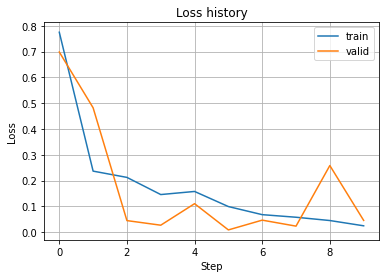

In [29]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

#### Скорость обучения влияет на метрику -- снижение скорости может улучшить метрику. Увеличение количества эпох может не приводить к улучшению метрики, так как метрика улучшается немонотонно.